# Regression

### Problem - Predict a Crocodile's age

You are employed by the UACA (United Association of Crocodiles and Aligators) and have a new task for you. Some of your colleagues,
(data collection officers) travel around the world and track crocodiles in the wild. They have just gotten back from a recent trip and
have a problem. They would like to predict the age of new crocodiles they begin tracking.

### Features

The data contains 2 features:

- weights (in pounds), will be denoted as $x^{(i)}$
- age (in months), will be denoted $y^{(i)}$

For simplicity, let us assume that ages behave like real numbers.

Note: this data is completely made up for the purpose of this tutorial.





### Data Visualizaton

Before we start our problem it is helpful to a look at the data we have:

<AxesSubplot:xlabel='weight', ylabel='age'>

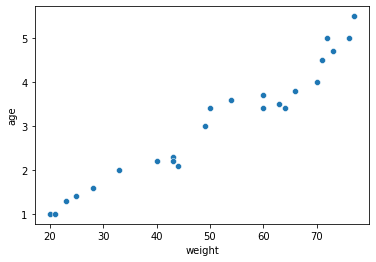

In [1]:
import pandas as pd
import seaborn as sns
import logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Import pseudo data set
df = pd.read_csv('../data/tabular/croc-age.csv')
training_data = pd.DataFrame({'weight': df.weight}).to_numpy()
labels =  pd.DataFrame({'age':df.age}).to_numpy() # age

#Visualize the data
sns.scatterplot(data=df, x="weight", y='age')

## Choosing a model

We can see that there might exist some linear relationship between our quantities. Thus let us use a linear model in the form of:
$ \^{y} = \theta x + \theta_0$ where  $\^{y}, x, \theta, \theta_0 \in R$.

### Evaluating our model

In terms of determining the correctness of our model and choosing an appropriate loss function, we will use least squares. That is for each data point we compare
our model $\^{y}^{(i)}$ with our observed value $y^{(i)}$ and square the result:

$
\[
\text{avg loss}  = \frac{1}{n} \sum_{i=0}^{n}
    ( y^{(i)} - \^{y}^{(i)})^2
\] \\
$


## Optimizing our model


### Visualizing loss

Now our goal is to find the `best' $\theta, \theta_0$. So we can visualize our loss function in 2d we will just start with searching for $\theta$.
Let's set up our objective function:

$J(\theta;\text{Data}) = \frac{1}{n} \sum_{i=0}^{n} ( y^{(i)} - (\theta * x^{(i)}))^2 $

And now let us visualize our loss function by running some values through $J$



(-70.0, 70.0)

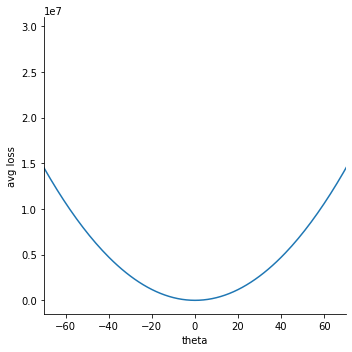

In [2]:
from regression import models, validate
import numpy as np

potential_theta_values =  [x / 1 for x in range(-100, 100)]
loss = []
for t in potential_theta_values:
        model = models.LinearRegression(theta=np.array([t]))
        loss.append(validate.avg_loss(model, training_data, labels))

plot = sns.relplot(x=potential_theta_values,y=loss, kind="line", facet_kws=dict(sharex=False))
plot.set(xlabel ="theta", ylabel = "avg loss")
plot.axes[0,0].set_xlim(-70,70)


By visual inspection we can see that our best theta is somewhere around .06. Let's overlay a line on our scatter plot to see what this looks like.

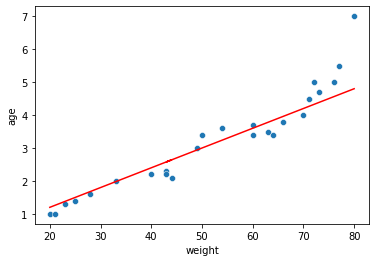

In [5]:
import numpy as np
from regression import models

#Visualize the data
plot = sns.scatterplot(data=df, x="weight", y='age')
model = models.LinearRegression(theta=np.array([.06]))

model_prediction = [model.predict(d) for d in training_data]
plot.plot(training_data, model_prediction, color='r')


### Gradient descent

Again by visual inspection we should note that our avg_loss function has a nice property,
it is convex. Loosely speaking this means that it has one global minimum. This is
extremely important to us, because we can use some mathematical techniques to estimate
its minimum.

To start, we will use a (very naive) iterative version of an algorithm called gradient descent to solve this problem.
The key insight to gradient descent, is that we will use the derivative to help us reach our global minimum.

At a high level the algorithm looks like:
   - choose a random value of $\theta$
   - uses the derivative to update $\theta$ in an intelligent way
   - stops when we reach our minimum

#### The usefulness of derivatives

If we determine the derivative at a point
   - larger derivatives -> nudging theta yields high loss
   - smaller derivatives -> nudging theta yields low loss
   - the sign of the derivative also points in the direction of ascent / descent

Thus, the derivative gives us 2 key pieces of information, how much to move and what direction to move.

1. In terms of the former, if the derivative is larger, this means we are very far from our minimum.
So we should take a 'big step' aka update our $\theta$ by a large value. And if the derivative is smaller,
this means we are very close to the minimum, so we should take a 'small step'.
So the distance to move = the derivative! More precisely we will define a hyperparameter 'step_size',
and the distance to move will actually be proportional to the derivative: distance = step_size * derivative.

2. In terms of the latter, we always want to move in the direction of the minimum. It can be helpful to reference
our graph where avg_loss was a function of theta. To build up intuition, let's imagine that we are increasing $\theta$
from negative values to positive values. Two things can happen:
      1. $J(\theta)$ increases. This means the derivative is positive and we are moving away from the minimum. Thus, we
         should nudge theta in the opposite direction. Derivative is +, change directions and move theta -.
      2. $J(\theta)$ decreases. This means the derivative is negative, and we are moving towards the minimum. Thus, we should
        nudge theta in the same direction. Derivative is -, continue in + direction
In both cases notice negating the sign of derivative, allows us to 'point' $\theta$ in the correct direction!


#### Computing the derivative

To start, let us define our objective function as:

$
J(\theta; x^{(i)}, y^{(i)}) =
\[
\frac{1}{n} \sum_{i=0}^{n}
    ( y^{(i)} - \theta * x^{(i)})^2
\]
$


The derivative w.r.t $\theta$,

$
\dfrac{d}{d\theta}
\[
\frac{1}{n} \sum_{i=0}^{n}
    ( y^{(i)} - \theta * x^{(i)})^2
\]
=
\[
\frac{1}{n} \sum_{i=0}^{n}
\dfrac{d}{d\theta} ( y^{(i)} - \theta * x^{(i)})^2
\]
=
\[
\frac{1}{n} \sum_{i=0}^{n}
-2( y^{(i)} - \theta * x^{(i)}) * x^{(i)}
\]
$




In [3]:

from regression import train, models, validate

d_theta = lambda x, y, theta: -2 * (y - (theta*x)) * x

results = train.gradient_descent(
        training_data
        , labels
        , derivative=d_theta
        , step_size=.00001
        , maximum_num_steps=100
)

gradient_model = results['model']
print(results['summary'])


#Visualize the data
# plot = sns.scatterplot(data=df, x="weight", y='age')
# model_prediction = [gradient_model.predict(d) for d in training_data]
# plot.plot(training_data, model_prediction, color='r')
#


(theta: 0.06, avg_loss: 0.12318333333333333) - Slope -> -162.12000000000023
(theta: 0.0616212, avg_loss: 0.11997452046327328) - Slope -> 67.1144375999999
(theta: 0.061117841718, avg_loss: 0.1193132857348903) - Slope -> -4.059416758236111
(theta: 0.06114067593726508, avg_loss: 0.11931095944144084) - Slope -> -0.8307038225925396
(theta: 0.06114418046901664, avg_loss: 0.11931087431973304) - Slope -> -0.3351700419855774
(theta: 0.061145240967977604, avg_loss: 0.11931086282242964) - Slope -> -0.1852176099028071
(theta: 0.06114568049804798, avg_loss: 0.11931085999948778) - Slope -> -0.12306893701205013
(theta: 0.06114589953431527, avg_loss: 0.11931085901762761) - Slope -> -0.09209764688910127
(theta: 0.061146022469833916, avg_loss: 0.1193108585903948) - Slope -> -0.07471481042395567
(theta: 0.0611460972690086, avg_loss: 0.11931085837401766) - Slope -> -0.06413835672256596
(theta: 0.06114614542709253, avg_loss: 0.11931085825215038) - Slope -> -0.05732889997101154
(theta: 0.061146177711011045,

{'converged': False, 'total_steps_until_convergence': 0, 'thetas': [0.0616212, 0.061117841718, 0.06114067593726508, 0.06114418046901664, 0.061145240967977604, 0.06114568049804798, 0.06114589953431527, 0.061146022469833916, 0.0611460972690086, 0.06114614542709253, 0.061146177711011045, 0.061146199995966016, 0.06114621571154517, 0.061146226970307145, 0.06114623513072288, 0.06114624109683818, 0.06114624548687436, 0.061146248732740625, 0.06114625114126555, 0.06114625293325937, 0.06114625426921939, 0.061146255266696536, 0.06114625601228849, 0.06114625657007203, 0.06114625698761831, 0.06114625730033372, 0.061146257534620704, 0.06114625771019572, 0.061146257841798154, 0.061146257940455674, 0.0611462580144239, 0.061146258069886064, 0.06114625811147481, 0.06114625814266194, 0.061146258166049794, 0.061146258183589285, 0.06114625819674312, 0.061146258206608045, 0.061146258214006495, 0.06114625821955519, 0.06114625822371663, 0.06114625822683767, 0.06114625822917842, 0.061146258230933975, 0.0611462

#### Computing the derivative

To start, let us define our objective function as:

$
J(\theta; x^{(i)}, y^{(i)}) =
\[
\frac{1}{n} \sum_{i=0}^{n}
    ( y^{(i)} - \theta * x^{(i)})^2
\]
$

And we want: $ argmin_\theta \  J(\theta; x^{(i)}, y^{(i)})$

To solve this optimization problem we need to calculate is the derivative w.r.t $\theta$,

$
\dfrac{d}{d\theta}
\[
\frac{1}{n} \sum_{i=0}^{n}
    ( y^{(i)} - \theta * x^{(i)})^2
\]
=
\[
\frac{1}{n} \sum_{i=0}^{n}
\dfrac{d}{d\theta} ( y^{(i)} - \theta * x^{(i)})^2
\]
=
\[
\frac{1}{n} \sum_{i=0}^{n}
2( y^{(i)} - \theta * x^{(i)}) * x^{(i)}
\]
$
